In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [5]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [6]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [7]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### LightGBM Ranker（candidate用のRankerモデル）

In [8]:
import xgboost as xgb
from sklearn.metrics import label_ranking_average_precision_score

# 特徴量とターゲットの定義
features = [x for x in train_df.columns if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'predict_no')] #predict_noを除く
target = 'target'

# XGBoost のパラメータ（GPU使用）
params = {
    'objective': 'rank:pairwise',  # ランキングタスク用の目的関数
    'eval_metric': 'map',  # MAPを評価指標とする
    'learning_rate': 0.05,
    'n_estimators': 30000,
    'max_depth': 6,
    'seed': 42531,
    'tree_method': 'gpu_hist'  # GPUを使用するための設定
}

In [9]:
map_scores = []
test_pred = []
oof_pred = np.zeros(len(train_df))

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # XGBoostデータセットを作成
    dtrain = xgb.DMatrix(train_data[features], label=train_data[target])
    dvalid = xgb.DMatrix(valid_data[features], label=valid_data[target])

    # モデルの訓練
    model = xgb.train(params, dtrain, num_boost_round=30000, evals=[(dvalid, 'eval')], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(dvalid)
    oof_pred[valid_data.index] = valid_pred
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    dtest = xgb.DMatrix(test_df[features])
    test_pred.append(model.predict(dtest))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


[13:51:47] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-map:0.08038
[1]	eval-map:0.08082
[2]	eval-map:0.08111
[3]	eval-map:0.08138
[4]	eval-map:0.08154
[5]	eval-map:0.08163
[6]	eval-map:0.08189
[7]	eval-map:0.08199
[8]	eval-map:0.08210
[9]	eval-map:0.08213
[10]	eval-map:0.08212
[11]	eval-map:0.08226
[12]	eval-map:0.08221
[13]	eval-map:0.08232
[14]	eval-map:0.08233
[15]	eval-map:0.08242
[16]	eval-map:0.08247
[17]	eval-map:0.08251
[18]	eval-map:0.08266
[19]	eval-map:0.08265
[20]	eval-map:0.08272
[21]	eval-map:0.08283
[22]	eval-map:0.08288
[23]	eval-map:0.08294
[24]	eval-map:0.08315
[25]	eval-map:0.08321
[26]	eval-map:0.08329
[27]	eval-map:0.08334
[28]	eval-map:0.08336
[29]	eval

           Feature  Importance
31   TE_sml_cd_var  133.741806
30  TE_sml_cd_mean   76.576576
1       max_seq_no   63.349869
22    count_lrg_cd   41.662216
10      popularity   32.162220


<Figure size 720x432 with 0 Axes>

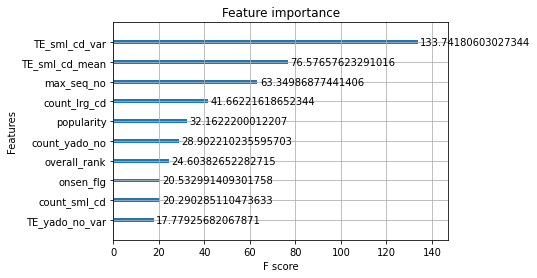

In [10]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# 以下はモデルの訓練コードと同様
# ...

# 特徴量重要度の取得
feature_importances = model.get_score(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importances_df = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# 重要度が高い上位の特徴量を表示
print(feature_importances_df.head())

# 特徴量重要度のグラフ表示
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.show()

In [11]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [12]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.156483
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.125275
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.332241
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.326264
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.827483


In [13]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.156483
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.125275
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.332241
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.326264
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.827483
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-9.658536
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-7.148248
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-6.155096
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-9.338915


In [14]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.156483
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.125275
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.332241
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.326264
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.827483
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-9.658536
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-7.148248
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-6.155096
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-9.338915


In [15]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/xgbRanker_ver2_oof_pred.csv', index=False)

In [16]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.156483
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.125275
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.332241
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.326264
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.827483
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-9.658536
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-7.148248
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-6.155096
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-9.338915


### CVの計算

In [17]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [18]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [19]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[902, 12491, 3894, 7749, 4072, 1284, 11380, 5490, 254]
CPU times: user 153 ms, sys: 21 µs, total: 153 ms
Wall time: 153 ms


In [20]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:52<00:00, 5545.51it/s]


In [21]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,997,12846,5289,11882,3324,9209,9208,9207
1,8253,4488,11104,3725,8747,2259,3564,1586,2570,8225
2,1967,5238,4355,9039,13642,4863,11724,2957,6722,7509
3,13549,7872,626,1341,7812,109,11715,755,13296,2272
4,96,902,12491,3894,7749,4072,1284,11380,5490,254
...,...,...,...,...,...,...,...,...,...,...
288693,10955,3725,13079,1586,13717,5719,13210,10522,8677,2876
288694,513,963,4767,2900,5299,8465,399,8703,6654,3940
288695,3566,4040,7308,7820,2087,9558,4398,12240,844,10364
288696,10619,7551,11091,12500,3238,570,12781,12829,10616,11316


### 要素の集合にバグがないかを確認

In [22]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [23]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [24]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [25]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
288668


In [26]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [27]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,997,12846,5289,11882,3324,9209,9208,9207
1,8253,4488,11104,3725,8747,2259,3564,1586,2570,8225
2,1967,5238,4355,9039,13642,4863,11724,2957,6722,7509
3,13549,7872,626,1341,7812,109,11715,755,13296,2272
4,96,902,12491,3894,7749,4072,1284,11380,5490,254
5,4823,10510,12544,5369,9199,9201,9202,9207,9200,1
6,4574,10378,7531,2282,10442,12774,2480,7273,441,13240
7,9508,12125,12962,12464,10362,7681,4744,10544,1755,111
8,1227,9723,3644,899,13220,12432,4014,3802,2164,13702
9,9773,6592,3278,3483,4303,10478,379,2806,550,9430


In [28]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [29]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [30]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4404338534352425


In [31]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [32]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [1]:
result_df.head(20)

NameError: name 'result_df' is not defined

### 推論用の候補テーブル作成

In [35]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [36]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[-0.5517924  -1.2834368   0.5359826  ...  0.4690101   0.898321
  0.67793024]
1683604


In [37]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [38]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [39]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,-0.551792
1,00001149e9c73985425197104712478c,4714,-1.283437
2,00001149e9c73985425197104712478c,2680,0.535983
3,00001149e9c73985425197104712478c,4420,-0.710205
4,00001149e9c73985425197104712478c,5466,-0.373656


In [40]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,-0.551792
1,00001149e9c73985425197104712478c,4714,-1.283437
2,00001149e9c73985425197104712478c,2680,0.535983
3,00001149e9c73985425197104712478c,4420,-0.710205
4,00001149e9c73985425197104712478c,5466,-0.373656
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.544082
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.432126
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.469010
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.898321


In [41]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,-0.551792
1,00001149e9c73985425197104712478c,4714,-1.283437
2,00001149e9c73985425197104712478c,2680,0.535983
3,00001149e9c73985425197104712478c,4420,-0.710205
4,00001149e9c73985425197104712478c,5466,-0.373656
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.544082
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.432126
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.469010
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.898321


In [42]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,-0.551792
1,00001149e9c73985425197104712478c,4714,-1.283437
2,00001149e9c73985425197104712478c,2680,0.535983
3,00001149e9c73985425197104712478c,4420,-0.710205
4,00001149e9c73985425197104712478c,5466,-0.373656
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.544082
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.432126
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.469010
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.898321


In [43]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/xgbRanker_ver2_test_pred.csv', index=False)

In [44]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [45]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[634, 12620, 867, 5623, 12767, 11994, 3781, 10729, 11723, 1891]
CPU times: user 88.1 ms, sys: 11.8 ms, total: 99.9 ms
Wall time: 100 ms


In [46]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:25<00:00, 6735.82it/s]


In [47]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,9830,2680,5466,11561,4420,9534,4714,6563,5785
1,11237,8108,12862,4066,7014,11923,6555,143,613,6129
2,757,410,9190,9910,6721,6730,13570,7710,1774,10485
3,12341,3359,6991,10861,13521,4180,6489,10746,5080,1542
4,3844,2862,9020,9623,5372,3476,10826,3854,12029,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,2278,5744,7062,3440,10042,10997,9743
174696,9723,12432,3802,1227,899,3644,4014,2164,13220,13702
174697,5810,7308,2087,13719,11796,13241,12939,11037,8143,13797
174698,2373,12281,5513,2692,10287,4976,3100,1687,3002,13672


In [48]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [49]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [50]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [51]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [52]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [53]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,9830,2680,5466,11561,4420,9534,4714,6563,5785,False
1,11237,8108,12862,4066,7014,11923,6555,143,613,6129,False
2,757,410,9190,9910,6721,6730,13570,7710,1774,10485,False
3,12341,3359,6991,10861,13521,4180,6489,10746,5080,1542,False
4,3844,2862,9020,9623,5372,3476,10826,3854,12029,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,2278,5744,7062,3440,10042,10997,9743,False
174696,9723,12432,3802,1227,899,3644,4014,2164,13220,13702,False
174697,5810,7308,2087,13719,11796,13241,12939,11037,8143,13797,False
174698,2373,12281,5513,2692,10287,4976,3100,1687,3002,13672,False


In [54]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/xgbRanker_ver2.csv', index=False)